# Pupil Testing

**Libraries**

In [1]:
# Prereqs
import cv2 as cv
import dlib
import numpy as np

# Our libraries
import pysight
from pysight.pupil_tools.pupil_combined import PupilTools
from pysight.pupil_tools.pupil_gradients import PupilGradients
from pysight.pupil_tools.pupil_isophotes import PupilIsophotes

# Inline plots
%matplotlib inline

**Images + Objects**

In [2]:
%ls tests/test_imgs/eye-crop-0.jpg

Parameter format not correct - "est_imgs".


In [3]:
# Test images
eye_control = 'tests\\test_imgs\\eye-crop-0.jpg'#'tests\\test_imgs\\eye-control.jpg'
eye_control_img = cv.imread(eye_control)

# Classifiers
pt = PupilTools()
pg = PupilGradients()
pi = PupilIsophotes(fast_width=25, weight_ratio_edge=0.75, weight_ratio_darkness=0.25)

In [4]:
#def draw_pupil_clf(control_img, )

(137, 110)


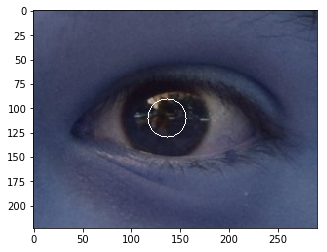

In [5]:
combined_center = pt.find_pupil(eye_control_img)
print (combined_center)
combined_viz = pysight.utils.drawing_utils.draw_circle(eye_control_img, combined_center[0], combined_center[1], 20)
pysight.utils.drawing_utils.cv2mpl(combined_viz, )

(140, 109)


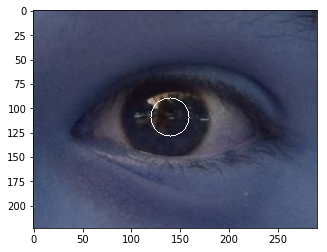

In [6]:
grad_center = pg.find_pupil(eye_control_img)
print (grad_center)
grad_viz = pysight.utils.drawing_utils.draw_circle(eye_control_img, grad_center[0], grad_center[1], 20)
pysight.utils.drawing_utils.cv2mpl(grad_viz)

In [7]:
iso_center = pi.find_pupil(eye_control_img)
print (iso_center)
iso_viz = pysight.utils.drawing_utils.draw_circle(eye_control_img, iso_center[0], iso_center[1], 20)
pysight.utils.drawing_utils.cv2mpl(iso_viz)

None


TypeError: 'NoneType' object is not subscriptable

In [8]:
__fast_width = 80.0
__min_rad = __fast_width / 8
__max_rad = __fast_width / 2

__weight_ratio_edge = 1
__weight_ratio_darkness = 0.0

__winname = "Pupil (isophote)"
__debug_imgs = {}

def get_gradients(img):

    """Find image gradients using OpenCV built-ins
    """
    
    f_x  = cv.Sobel(img, ddepth=cv.CV_32F, dx=1, dy=0, ksize=9)
    f_y  = cv.Sobel(img, ddepth=cv.CV_32F, dx=0, dy=1, ksize=9)
    f_xy = cv.Sobel(img, ddepth=cv.CV_32F, dx=1, dy=1, ksize=9)
    f_xx = cv.Sobel(img, ddepth=cv.CV_32F, dx=2, dy=0, ksize=9)
    f_yy = cv.Sobel(img, ddepth=cv.CV_32F, dx=0, dy=2, ksize=9)
    
    return f_x, f_y, f_xy, f_xx, f_yy
def get_center_map(eye_img):

    f_x, f_y, f_xy, f_xx, f_yy = get_gradients(eye_img)

    # Calculate the curved-ness and weighting function
    curvedness = np.sqrt(f_xx ** 2 + 2 * f_xy ** 2 + f_yy ** 2)
    curvedness_norm = cv.normalize(curvedness, 0, 255, norm_type=cv.NORM_MINMAX).astype(np.uint8)

    weight_edge = cv.normalize(curvedness, 0, 255 * __weight_ratio_edge, norm_type=cv.NORM_MINMAX)               # higher weight to stronger edges
    weight_middle = cv.normalize((255 - eye_img), 0, 255 * __weight_ratio_darkness, norm_type=cv.NORM_MINMAX)       # higher center weight to darker areas
    
    # Calculate the displacement vectors
    temp_top = f_x ** 2 + f_y ** 2
    temp_bot = ((f_y ** 2) * f_xx) - (2 * f_x * f_xy * f_y) + ((f_x ** 2) * f_yy) + 0.0001      # hack to offset against division by 0
    d_vec_mul = -temp_top / temp_bot
    d_vec_x = d_vec_mul * f_x
    d_vec_y = d_vec_mul * f_y
    
    # Remove infinite displacements for straight lines
    d_vec_x = np.nan_to_num(d_vec_x)
    d_vec_y = np.nan_to_num(d_vec_y)
    mag_d_vec = cv.magnitude(d_vec_x, d_vec_y)
    
    # Prevent using weights with bad radius sizes
    weight_edge[mag_d_vec < __min_rad] = 0
    weight_edge[mag_d_vec > __max_rad] = 0
    
    # Calculate curvature to ensure we use gradients which point in right direction
    curvature = temp_bot / (0.0001 + (temp_top ** 1.5))
    weight_edge[curvature < 0] = 0
    weight_edge[curvedness_norm < 20] = 0
    
    # Make indexes into accumulator using basic grid and vector offsets
    grid = np.indices(eye_img.shape[:2], np.uint8)
    acc_inds_x = grid[1] + d_vec_x.astype(int)
    acc_inds_y = grid[0] + d_vec_y.astype(int)
    
    # Prevent indexing outside of accumulator
    acc_inds_x[acc_inds_x < 0] = 0
    acc_inds_y[acc_inds_y < 0] = 0
    acc_inds_x[acc_inds_x >= eye_img.shape[1]] = 0
    acc_inds_y[acc_inds_y >= eye_img.shape[0]] = 0
    
    # Make center map accumulator
    accumulator = np.zeros(eye_img.shape[:2])
    
    # Use numpy fancy indexing to add weights in one go
    # (This is fast as it avoids python loops)
    accumulator[acc_inds_y, acc_inds_x] += weight_edge
    accumulator += weight_middle
    
    # Post-processing
    morph_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    accumulator = cv.morphologyEx(accumulator, cv.MORPH_DILATE, morph_kernel)
    # accumulator = cv.blur(accumulator, (10, 10))
    accumulator = cv.GaussianBlur(accumulator, (13, 13), 0)
    
    return accumulator


def find_pupil(eye_img_bgr):
    
    eye_img_r = cv.cvtColor(eye_img_bgr, cv.COLOR_BGR2GRAY)
    
    # Scale to small image for faster computation
    scale = __fast_width / eye_img_r.shape[1]
    small_size = (int(__fast_width), int((__fast_width / eye_img_r.shape[1]) * eye_img_r.shape[0]))
    eye_img_small = cv.resize(eye_img_r, small_size)
    eye_img_small = cv.GaussianBlur(eye_img_small, (3, 3), 0)
    
    center_map = get_center_map(eye_img_small)
    
    max_val_index = np.argmax(center_map)
    pupil_y0, pupil_x0 = max_val_index // center_map.shape[1], max_val_index % center_map.shape[1]
    
    # Scale back to original coordinates
    pupil_y0, pupil_x0 = int((pupil_y0 + 0.5) / scale), int((pupil_x0 + 0.5) / scale)

In [9]:
iso_center = find_pupil(eye_control_img)
print (iso_center)
iso_viz = pysight.utils.drawing_utils.draw_circle(eye_control_img, iso_center[0], iso_center[1], 20)
pysight.utils.drawing_utils.cv2mpl(iso_viz)

None


TypeError: 'NoneType' object is not subscriptable

***Pupil Isophotes not working!***